In [27]:
from dataprep.eda import create_report
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as seas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import wbgapi as wb

seas.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [3]:
indexes = ['EN.ATM.CO2E.KT',        #CO2 emissions (kt)
           'NY.GDP.MKTP.PP.KD',     #GDP per capita, PPP (constant 2017 international $)
           'SP.POP.TOTL',           #Population, total 
           'EG.FEC.RNEW.ZS',        #Renewable energy consumption (% of total final energy
           'SP.URB.TOTL.IN.ZS',     #Urban population (% of total population) 
           'NV.MNF.TECH.ZS.UN',     #Medium and high-tech manufacturing value added (% manufacturing value added)
           'NE.TRD.GNFS.ZS']        #Trade (% of GDP)

In [4]:
countries = ['Argentina',
'Armenia',
'Australia',
'Austria',
'Belgium',
'Bulgaria',
'Belarus',
'Brazil',
'Canada',
'Switzerland',
'Chile',
'China',
'Colombia',
'Czech Republic',
'Germany',
'Denmark',
'Spain',
'Estonia',
'Finland',
'France',
'United Kingdom',
'Georgia',
'Greece',
'Croatia',
'Hungary',
'India',
'Ireland',
'Iceland',
'Israel',
'Italy',
'Japan',
'Kazakhstan',
'Korea, Rep.',
'Lithuania',
'Latvia',
'Moldova',
'Mexico',
'Malaysia',
'Netherlands',
'Norway',
'New Zealand',
'Panama',
'Peru',
'Poland',
'Portugal',
'Romania',
'Russian Federation',
'Singapore',
'Serbia',
'Slovak Republic',
'Slovenia',
'Sweden',
'Turkey',
'Ukraine',
'United States',
'South Africa'] 

In [5]:
countries = [wb.economy.coder(country) for country in countries]

In [6]:
raw_dataset = wb.data.DataFrame(series = indexes, economy = countries, time = range(1994,2023), labels=True,columns='series')

In [7]:
raw_dataset.unstack(0).stack()

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  \
time   economy                                                        
YR2021 ZAF       South Africa  2021             NaN             NaN   
       USA      United States  2021             NaN             NaN   
       UKR            Ukraine  2021             NaN             NaN   
       TUR            Turkiye  2021             NaN             NaN   
       SWE             Sweden  2021             NaN             NaN   
...                       ...   ...             ...             ...   
YR1994 BEL            Belgium  1994        0.939573        114900.0   
       AUT            Austria  1994       25.679455         58280.0   
       AUS          Australia  1994        8.259947        280180.0   
       ARM            Armenia  1994       17.763653          2740.0   
       ARG          Argentina  1994       10.734909        111910.0   

                NE.TRD.GNFS.ZS  NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD  \
time   economy                                                         
YR2021 ZAF           56.071227                NaN       7.881121e+11   
       USA                 NaN                NaN       2.093228e+13   
       UKR           82.621300                NaN       5.355789e+11   
       TUR           71.212724                NaN       2.657762e+12   
       SWE           88.162017                NaN       5.525622e+11   
...                        ...                ...                ...   
YR1994 BEL          113.232300          14.080100       3.740897e+11   
       AUT           65.987093          36.610757       3.129625e+11   
       AUS           36.458731          27.756124       5.726639e+11   
       ARM          112.429365          28.824233       9.053823e+09   
       ARG           18.134346          29.628354       6.224138e+11   

                SP.POP.TOTL  SP.URB.TOTL.IN.ZS  
time   economy                                  
YR2021 ZAF       60041996.0             67.847  
       USA      331893745.0             82.873  
       UKR       43814581.0             69.757  
       TUR       85042736.0             76.569  
       SWE       10415811.0             88.238  
...                     ...                ...  
YR1994 BEL       10115603.0             96.700  
       AUT        7936118.0             61.870  
       AUS       17855000.0             85.028  
       ARM        3283664.0             66.332  
       ARG       34402669.0             87.960  

[1568 rows x 9 columns]

# Overview

In [10]:
col = ['Number of variables',
'Number of observations',
'Missing cells',
'Missing cells (%)',
'Rows with Missing cells',
'Rows with Missing cells (%)',
'Duplicate rows',
'Duplicate rows (%)']

val = [len(raw_dataset.columns),
len(raw_dataset),
raw_dataset.isna().values.sum(),
(raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
len(raw_dataset) - len(raw_dataset.dropna()),
((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
raw_dataset.duplicated().sum(),
raw_dataset.duplicated().sum()]

val = list(map(round,val))

overview = pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

In [11]:
overview

Variables  Count
0          Number of variables      9
1       Number of observations   1568
2                Missing cells    362
3            Missing cells (%)     23
4      Rows with Missing cells    125
5  Rows with Missing cells (%)      8
6               Duplicate rows      0
7           Duplicate rows (%)      0

## Data preprocessing

### Missing value check


In [12]:
raw_dataset.isna().sum()

Country                0
Time                   0
EG.FEC.RNEW.ZS       112
EN.ATM.CO2E.KT       112
NE.TRD.GNFS.ZS        14
NV.MNF.TECH.ZS.UN    112
NY.GDP.MKTP.PP.KD     12
SP.POP.TOTL            0
SP.URB.TOTL.IN.ZS      0
dtype: int64

In [13]:
raw_dataset = raw_dataset.dropna()

### Outlier detection and treatment

In [14]:
def outlier_treatment(dataset):
    """
    
    Values lying outside 3SD are considered as outliers for this analysis
    Outlier values are treated with mean of that column
    
    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    Dataframe with treated outlier values
    """
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset,outlier_summary

processed_df,outlier_summary = outlier_treatment(raw_dataset)

outlier_summary

Variables  No. of Outliers
0     EG.FEC.RNEW.ZS               14
1     EN.ATM.CO2E.KT               43
2     NE.TRD.GNFS.ZS               27
3  NV.MNF.TECH.ZS.UN               10
4  NY.GDP.MKTP.PP.KD               38
5        SP.POP.TOTL               52
6  SP.URB.TOTL.IN.ZS               10

### Calculating Column of Intrest

In [15]:
processed_df

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  \
economy time                                                         
ZAF     YR2019  South Africa  2019       10.500000   439640.014648   
        YR2018  South Africa  2018       10.190000   434350.006104   
        YR2017  South Africa  2017       10.450000   435649.993896   
        YR2016  South Africa  2016       10.530000   425140.014648   
        YR2015  South Africa  2015       10.280000   424809.997559   
...                      ...   ...             ...             ...   
ARG     YR1998     Argentina  1998       11.343009   132670.000000   
        YR1997     Argentina  1997       10.999073   126120.000000   
        YR1996     Argentina  1996       10.193856   122550.000000   
        YR1995     Argentina  1995       11.205185   112890.000000   
        YR1994     Argentina  1994       10.734909   111910.000000   

                NE.TRD.GNFS.ZS  NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD  \
economy time                                                           
ZAF     YR2019       54.150246          24.428034       8.028319e+11   
        YR2018       54.507584          24.428034       8.019253e+11   
        YR2017       53.535932          24.428034       7.901706e+11   
        YR2016       55.861258          24.428034       7.811255e+11   
        YR2015       56.726676          24.428034       7.759688e+11   
...                        ...                ...                ...   
ARG     YR1998       23.350028          30.443321       7.164454e+11   
        YR1997       23.336179          30.983214       6.898836e+11   
        YR1996       21.506468          28.563551       6.381250e+11   
        YR1995       19.771423          27.200513       6.047048e+11   
        YR1994       18.134346          29.628354       6.224138e+11   

                SP.POP.TOTL  SP.URB.TOTL.IN.ZS  
economy time                                    
ZAF     YR2019   58558267.0             66.856  
        YR2018   57792520.0             66.355  
        YR2017   57009751.0             65.850  
        YR2016   56207649.0             65.341  
        YR2015   55386369.0             64.828  
...                     ...                ...  
ARG     YR1998   36063451.0             88.759  
        YR1997   35657438.0             88.564  
        YR1996   35246376.0             88.366  
        YR1995   34828168.0             88.164  
        YR1994   34402669.0             87.960  

[1443 rows x 9 columns]

In [16]:
processed_df['CO2.PER.CAP'] = processed_df['EN.ATM.CO2E.KT']/processed_df['SP.POP.TOTL']

C:\Users\Student.DESKTOP-282GMUV\AppData\Local\Temp\ipykernel_16896\2365068172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['CO2.PER.CAP'] = processed_df['EN.ATM.CO2E.KT']/processed_df['SP.POP.TOTL']


## Exploratory Data Analysis

### Data Summary


In [17]:
processed_df.describe(include='all')

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  NE.TRD.GNFS.ZS  \
count           1443  1443     1443.000000    1.443000e+03     1443.000000   
unique            56    26             NaN             NaN             NaN   
top     South Africa  2019             NaN             NaN             NaN   
freq              26    56             NaN             NaN             NaN   
mean             NaN   NaN       17.419506    2.490058e+05       81.242053   
std              NaN   NaN       14.154456    4.190155e+05       39.861393   
min              NaN   NaN        0.330000    1.630000e+03       13.388233   
25%              NaN   NaN        6.375000    3.829000e+04       53.191604   
50%              NaN   NaN       13.090000    6.970000e+04       72.481643   
75%              NaN   NaN       26.895276    3.353500e+05      102.375971   
max              NaN   NaN       62.470000    3.810060e+06      227.401952   

        NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD   SP.POP.TOTL  SP.URB.TOTL.IN.ZS  \
count         1443.000000       1.443000e+03  1.443000e+03        1443.000000   
unique                NaN                NaN           NaN                NaN   
top                   NaN                NaN           NaN                NaN   
freq                  NaN                NaN           NaN                NaN   
mean            35.370740       9.195125e+11  3.623742e+07          71.874688   
std             15.390999       1.273255e+12  5.297423e+07          13.807083   
min              3.904432       9.004634e+09  2.674680e+05          28.903000   
25%             24.411546       1.514772e+11  5.264671e+06          61.775000   
50%             36.077712       3.734972e+11  1.086213e+07          73.504000   
75%             46.301215       1.222087e+12  4.741090e+07          81.508500   
max             83.065751       9.140468e+12  3.283300e+08         100.000000   

        CO2.PER.CAP  
count   1443.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       0.007194  
std        0.004817  
min        0.000744  
25%        0.004115  
50%        0.006603  
75%        0.009088  
max        0.048803

### Log Trasforming the data

In [18]:
for c in [c for c in processed_df.columns[2:]]:
    processed_df[c] = np.log10(processed_df[c] + 1)

C:\Users\Student.DESKTOP-282GMUV\AppData\Local\Temp\ipykernel_16896\3581536921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[c] = np.log10(processed_df[c] + 1)


In [19]:
fig,axes = plt.subplots(4,2,figsize = (15,6))

seas.histplot(processed_df.iloc[:,2],kde=True,stat = 'density', ax=axes[0,0])
seas.histplot(processed_df.iloc[:,3],kde=True,stat = 'density',color='green',ax=axes[0,1])
seas.histplot(processed_df.iloc[:,4],kde=True,stat = 'density', color='r',ax=axes[1,0])
seas.histplot(processed_df.iloc[:,5],kde=True,stat = 'density', color='y',ax=axes[1,1])
seas.histplot(processed_df.iloc[:,6],kde=True,stat = 'density',ax=axes[2,0])
seas.histplot(processed_df.iloc[:,7],kde=True,stat = 'density',color='green',ax=axes[2,1])
seas.histplot(processed_df.iloc[:,8],kde=True,stat = 'density', color='r',ax=axes[3,0])
seas.histplot(processed_df.iloc[:,9],kde=True,stat = 'density', color='y',ax=axes[3,1])

<AxesSubplot:xlabel='CO2.PER.CAP', ylabel='Density'>

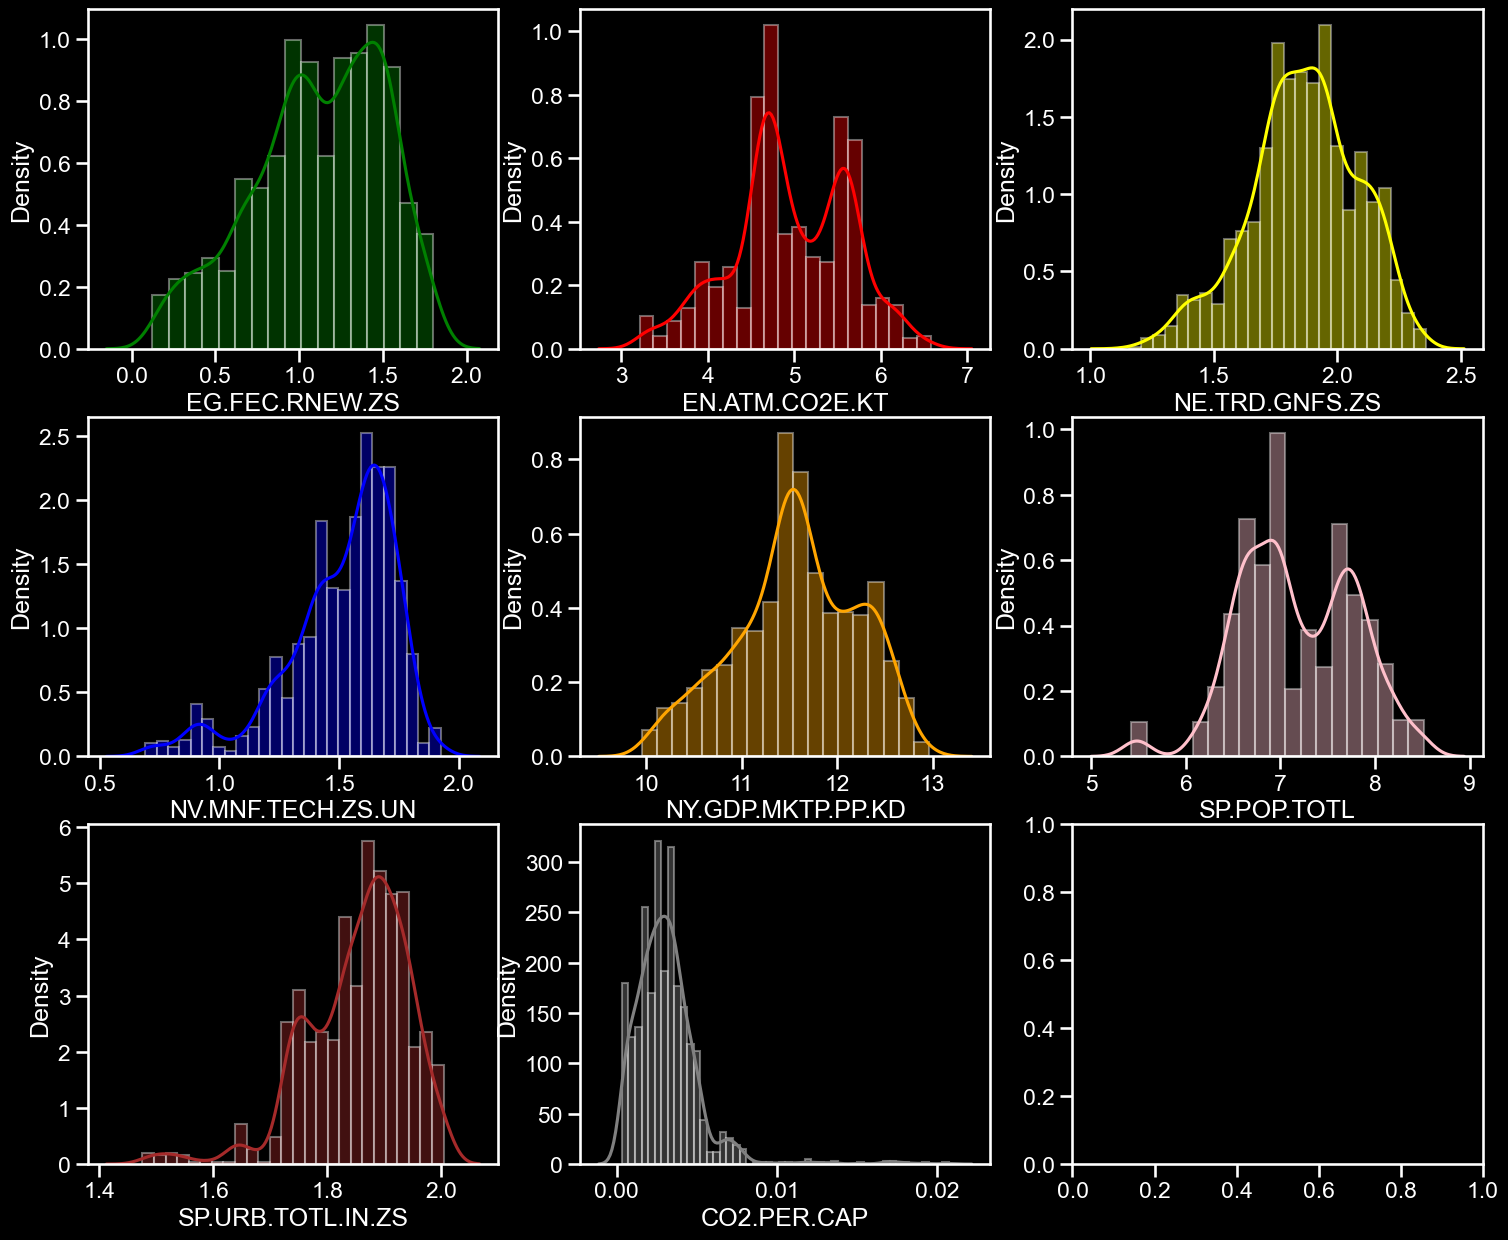

In [44]:
%matplotlib inline

n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[2:]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols])

### Pair Plots

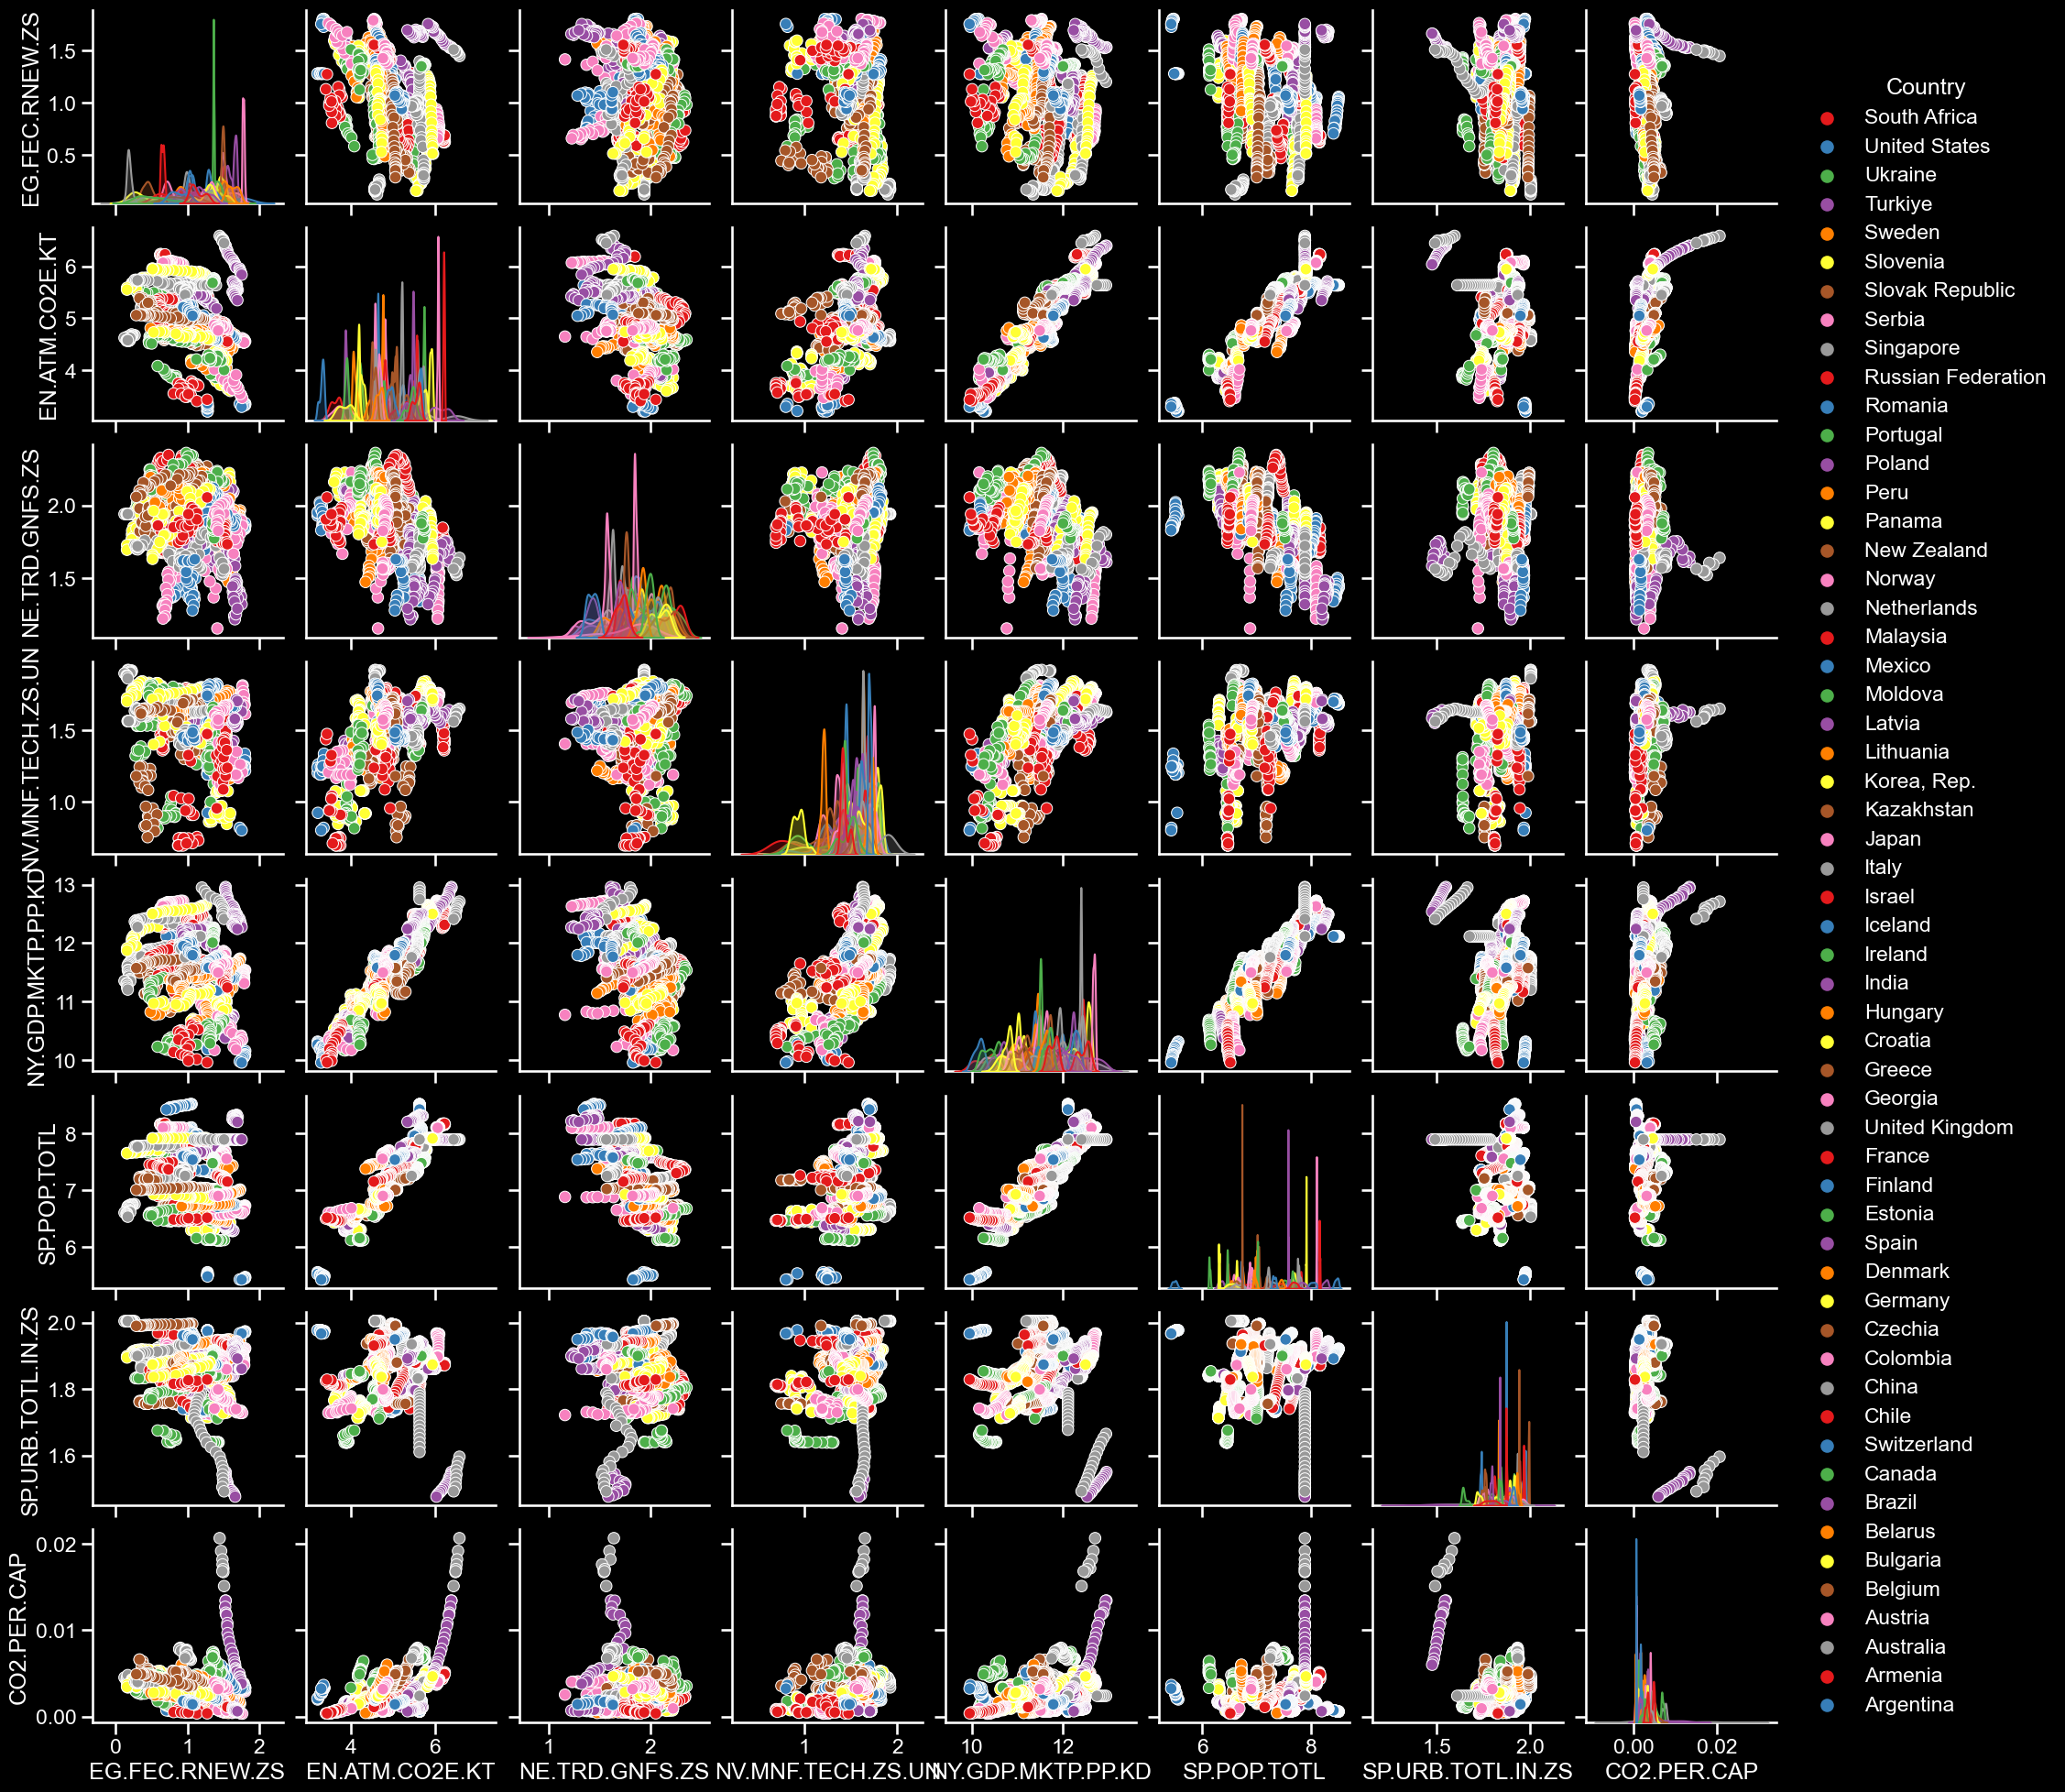

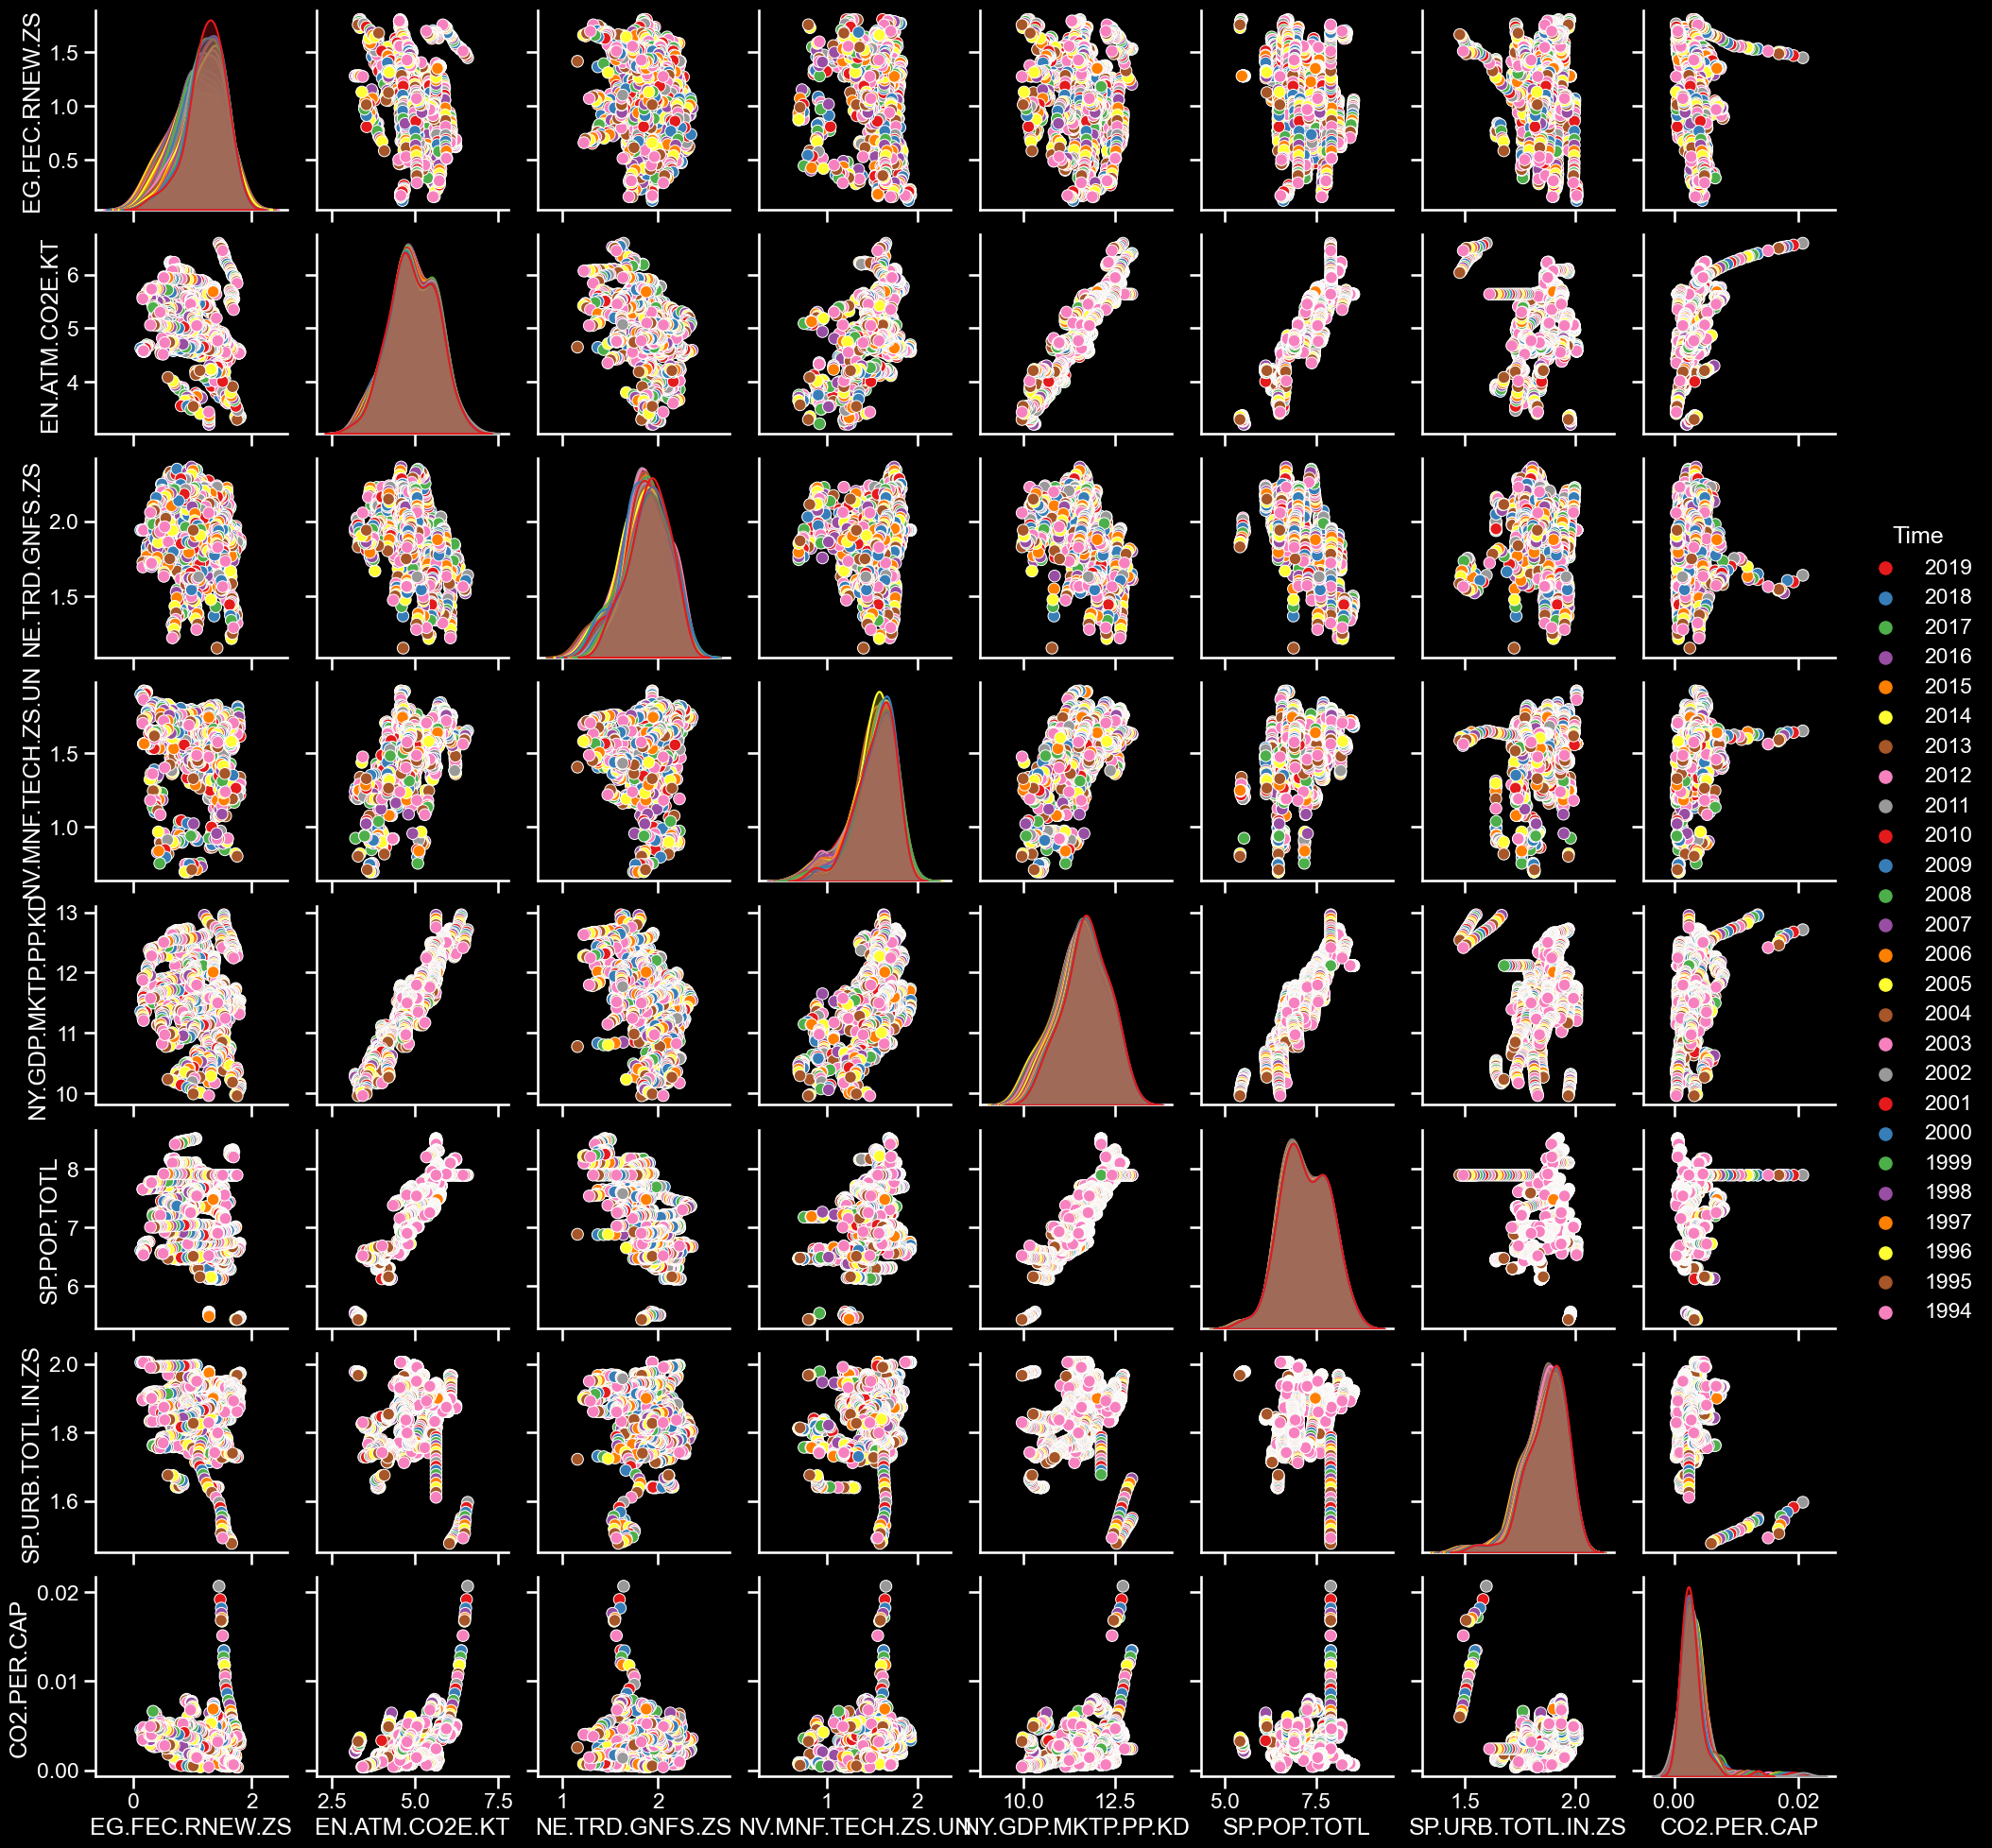

In [50]:
seas.pairplot(data=processed_df,  hue='Country',palette="Set1")
seas.pairplot(data=processed_df,  hue='Time',palette="Set1")